In [1]:
import numpy as np
import tensorflow as tf
import json
import scipy.io as sio
import random
import os
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Top-K sparsity

class SparseAutoencoder(nn.Module):
    def __init__(self, in_channels=1, num_kernels=16, kernel_size=7, k=5):
        super().__init__()
        self.k = k

        self.encoder = nn.Conv2d(in_channels, num_kernels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.decoder = nn.ConvTranspose2d(num_kernels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2)
    
    def forward(self, x):
        z = self.encoder(x)

        epsilon = 1e-6
        B, C, H, W = z.shape
        z_flat = z.view(B, C, -1)
        topk_vals, _ = torch.topk(torch.abs(z_flat), self.k, dim=2)
        threshold = topk_vals[:, :, -1].unsqueeze(-1)
        z_sparse = torch.where(torch.abs(z_flat) >= threshold, z_flat, torch.zeros_like(z_flat))
        z_sparse = torch.where(torch.abs(z_flat) >= (threshold - epsilon), z_flat, torch.zeros_like(z_flat))
        z_sparse = z_sparse.view_as(z)

        x_recon = self.decoder(z_sparse)
        return x_recon, z_sparse


In [3]:
n_pix = 96

print('Loading ' +str(40) + ' examples.')

    # Initialize output arrays
set_x = np.zeros((40, n_pix, n_pix, 250))
set_y = np.zeros((40, n_pix, n_pix))

data_list = [i for i in range(40)]

    # Shuffle set list
np.random.seed(1)
np.random.shuffle(data_list)

for k in range(40):
        # Load dataset
    data_dir = r"D:\fUSI\Code base\test_data\test" + r"\fr" + str(k + 1) + ".mat"
    mat_contents = sio.loadmat(data_dir)


    idx = data_list[k]

    set_x[idx] = mat_contents['x'][:,:,:250]
    set_y[idx] = mat_contents['y']

print('Done loading ' +str(40) +' examples.')

Loading 40 examples.
Done loading 40 examples.


In [4]:
set_x.shape, set_y.shape

((40, 96, 96, 250), (40, 96, 96))

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class DopplerDataset(Dataset):
    def __init__(self, set_y):
        self.data = set_y.astype(np.float32)
        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())  # normalize
        self.data = self.data[:, np.newaxis, :, :]  # (N, 1, H, W)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

# create dataset and dataloader
dataset = DopplerDataset(set_y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SparseAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        x_recon, _ = model(batch)
        loss = loss_fn(x_recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

cpu
Epoch 1, Loss: 0.0563
Epoch 2, Loss: 0.0397
Epoch 3, Loss: 0.0366
Epoch 4, Loss: 0.0344
Epoch 5, Loss: 0.0325
Epoch 6, Loss: 0.0308
Epoch 7, Loss: 0.0292
Epoch 8, Loss: 0.0283
Epoch 9, Loss: 0.0273
Epoch 10, Loss: 0.0265
Epoch 11, Loss: 0.0257
Epoch 12, Loss: 0.0253
Epoch 13, Loss: 0.0249
Epoch 14, Loss: 0.0243
Epoch 15, Loss: 0.0242
Epoch 16, Loss: 0.0239
Epoch 17, Loss: 0.0232
Epoch 18, Loss: 0.0232
Epoch 19, Loss: 0.0224
Epoch 20, Loss: 0.0224


In [7]:
import matplotlib.pyplot as plt

def visualize_kernels(model, title="Learned Kernels", cmap='gray'):
    """
    Visualizes the convolutional kernels (filters) of the encoder.

    Parameters:
    - model: Trained SparseAutoencoder model
    - title: Title for the plot
    - cmap: Colormap to use for visualization
    """
    kernels = model.encoder.weight.data.cpu()
    num_kernels = kernels.shape[0]
    in_channels = kernels.shape[1]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(1, num_kernels, figsize=(num_kernels * 2, 2))
    if num_kernels == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx in range(num_kernels):
        kernel = kernels[idx, 0]  # Assuming in_channels=1
        axes[idx].imshow(kernel, cmap=cmap)
        axes[idx].axis('off')
        axes[idx].set_title(f'K{idx}')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Dense --> Patch wise
# Shallow 

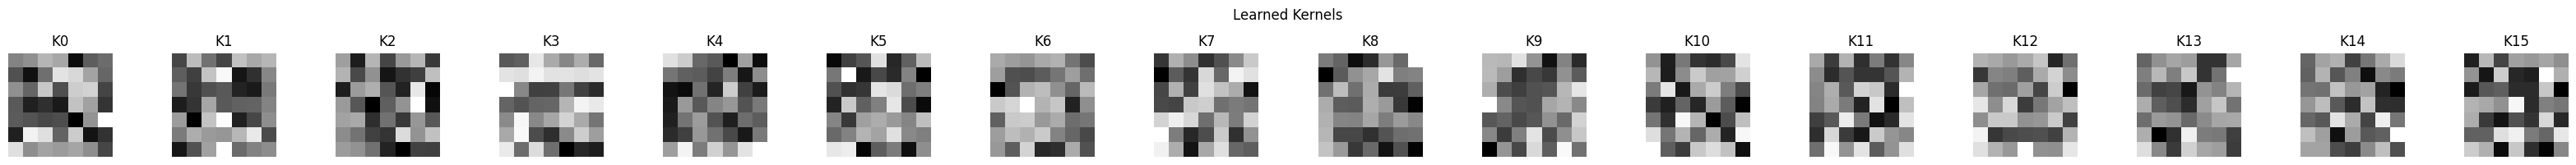

In [8]:

visualize_kernels(model)

In [33]:
model.eval()
sample = next(iter(dataloader))[0].to(device)  # Get only the image tensor if dataset returns (image, label)
recon, _ = model(sample)

plt.figure(figsize=(10, 4))
num_images = min(4, sample.size(0))  # Avoid going out of bounds

for i in range(num_images):
    plt.subplot(2, num_images, i+1)
    plt.imshow(sample[i, 0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(recon[i, 0].detach().cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 4, got 3)

In [9]:
import matplotlib.pyplot as plt

def show_saliency_regions(model, sample_img):
    model.eval()
    sample_img = sample_img.unsqueeze(0).to(device)  # shape (1, 1, H, W)
    recon, z_sparse = model(sample_img)

    # Get top activated atoms
    top_atoms = get_top_atoms(z_sparse, top_n=3)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    axes[0].imshow(sample_img[0, 0].cpu(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, atom_idx in enumerate(top_atoms):
        saliency_map = z_sparse[0, atom_idx].abs().detach().cpu().numpy()
        axes[i+1].imshow(saliency_map, cmap='hot')
        axes[i+1].set_title(f"Atom {atom_idx}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
def get_top_atoms(z_sparse, top_n=3):
    # z_sparse: (1, C, H, W)
    atom_strengths = z_sparse.abs().sum(dim=(2, 3))  # shape: (1, C)
    top_atoms = torch.topk(atom_strengths, top_n, dim=1).indices[0].cpu().numpy()
    return top_atoms

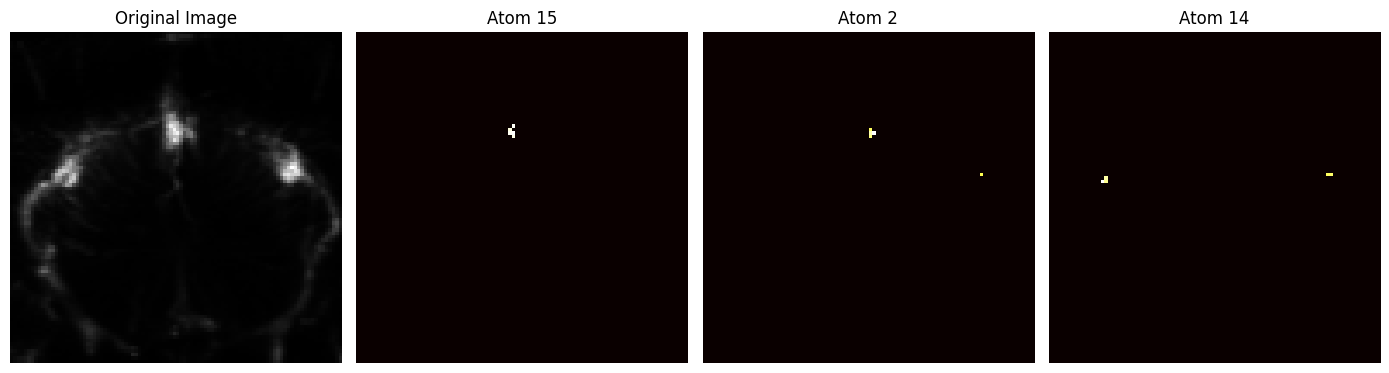

In [22]:
# Pick a test sample
sample_batch = next(iter(dataloader))
sample_img = sample_batch[0]  # One image

show_saliency_regions(model, sample_img)


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Dataset ---
class DopplerDataset(Dataset):
    def __init__(self, set_y):
        self.data = set_y.astype(np.float32)
        self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())  # normalize
        self.data = self.data[:, np.newaxis, :, :]  # (N, 1, H, W)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])
    
# create dataset and dataloader
dataset = DopplerDataset(set_y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [47]:
class SparseAutoencoder(nn.Module):
    def __init__(self, in_channels=1, num_kernels=16, kernel_size=7):
        super().__init__()
        self.encoder = nn.Conv2d(in_channels, num_kernels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.decoder = nn.ConvTranspose2d(num_kernels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2)
    
    def forward(self, x):
        z = self.encoder(x)

        # Top-K sparsity
        k = 5
        B, C, H, W = z.shape
        z_flat = z.view(B, C, -1)
        topk_vals, _ = torch.topk(torch.abs(z_flat), k, dim=2)
        threshold = topk_vals[:, :, -1].unsqueeze(-1)
        z_sparse = torch.where(torch.abs(z_flat) >= threshold, z_flat, torch.zeros_like(z_flat))
        z_sparse = z_sparse.view_as(z)

        x_recon = self.decoder(z_sparse)
        return x_recon, z_sparse

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

model = SparseAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# --- Training loop ---
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        x_recon, _ = model(batch)
        loss = loss_fn(x_recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Using device: cpu
Epoch 1, Loss: 0.0472
Epoch 2, Loss: 0.0371
Epoch 3, Loss: 0.0337
Epoch 4, Loss: 0.0317
Epoch 5, Loss: 0.0305
Epoch 6, Loss: 0.0288
Epoch 7, Loss: 0.0279
Epoch 8, Loss: 0.0275
Epoch 9, Loss: 0.0264
Epoch 10, Loss: 0.0256
Epoch 11, Loss: 0.0252
Epoch 12, Loss: 0.0256
Epoch 13, Loss: 0.0246
Epoch 14, Loss: 0.0243
Epoch 15, Loss: 0.0239
Epoch 16, Loss: 0.0231
Epoch 17, Loss: 0.0226
Epoch 18, Loss: 0.0225
Epoch 19, Loss: 0.0232
Epoch 20, Loss: 0.0227
Epoch 21, Loss: 0.0224
Epoch 22, Loss: 0.0216
Epoch 23, Loss: 0.0217
Epoch 24, Loss: 0.0215
Epoch 25, Loss: 0.0215
Epoch 26, Loss: 0.0215
Epoch 27, Loss: 0.0209
Epoch 28, Loss: 0.0215
Epoch 29, Loss: 0.0216
Epoch 30, Loss: 0.0210
Epoch 31, Loss: 0.0200
Epoch 32, Loss: 0.0202
Epoch 33, Loss: 0.0200
Epoch 34, Loss: 0.0198
Epoch 35, Loss: 0.0199
Epoch 36, Loss: 0.0200
Epoch 37, Loss: 0.0197
Epoch 38, Loss: 0.0194
Epoch 39, Loss: 0.0197
Epoch 40, Loss: 0.0194
Epoch 41, Loss: 0.0192
Epoch 42, Loss: 0.0196
Epoch 43, Loss: 0.0192
Ep

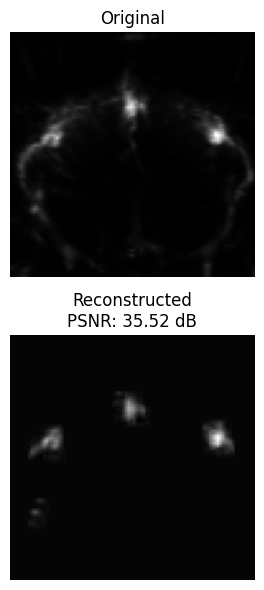

In [56]:
# --- PSNR calculation ---
def calculate_psnr(reconstructed, original, max_val=1.0):
    mse = F.mse_loss(reconstructed, original, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(dim=1)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse + 1e-8))
    return psnr

# --- Evaluation and Visualization ---
def evaluate_and_visualize(model, dataloader, device):
    model.eval()
    sample = next(iter(dataloader)).to(device)  # (B, 1, H, W)
    with torch.no_grad():
        recon, _ = model(sample)

    psnr_scores = calculate_psnr(recon, sample)

    num_images = min(4, sample.size(0))
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(sample[i, 0].cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(recon[i, 0].cpu(), cmap='gray')
        plt.title(f"Reconstructed\nPSNR: {psnr_scores[i]:.2f} dB")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Call after training ---
evaluate_and_visualize(model, dataloader,device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- Sparse Autoencoder ---
class SparseAutoencoder(nn.Module):
    def __init__(self, in_channels=1, num_kernels=16, kernel_size=7):
        super().__init__()
        self.encoder = nn.Conv2d(in_channels, num_kernels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.decoder = nn.ConvTranspose2d(num_kernels, in_channels, kernel_size=kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        z = self.encoder(x)
        k = 5  # Top-K sparsity
        B, C, H, W = z.shape
        z_flat = z.view(B, C, -1)
        topk_vals, _ = torch.topk(torch.abs(z_flat), k, dim=2)
        threshold = topk_vals[:, :, -1].unsqueeze(-1)
        z_sparse = torch.where(torch.abs(z_flat) >= threshold, z_flat, torch.zeros_like(z_flat))
        z_sparse = z_sparse.view_as(z)
        x_recon = self.decoder(z_sparse)
        return x_recon, z_sparse

# --- PSNR ---
def calculate_psnr(reconstructed, original, max_val=1.0):
    mse = F.mse_loss(reconstructed, original, reduction='none')
    mse = mse.view(mse.size(0), -1).mean(dim=1)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse + 1e-8))
    return psnr

# --- Visualize ---
def evaluate_and_visualize(model, dataloader, device):
    model.eval()
    sample = next(iter(dataloader))[0].to(device)  # (B, 1, 28, 28)
    with torch.no_grad():
        recon, _ = model(sample)

    psnr_scores = calculate_psnr(recon, sample)
    num_images = min(4, sample.size(0))
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(sample[i, 0].cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(recon[i, 0].cpu(), cmap='gray')
        plt.title(f"Reconstructed\nPSNR: {psnr_scores[i]:.2f} dB")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to (C, H, W) and normalizes [0,1]
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)

# Initialize model
model = SparseAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# --- Training ---
for epoch in range(50):  # You can increase to 20+
    model.train()
    total_loss = 0
    for batch, _ in dataloader:  # Discard labels
        batch = batch.to(device)
        x_recon, _ = model(batch)
        loss = loss_fn(x_recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# --- Evaluation ---
evaluate_and_visualize(model, dataloader, device)

Device: cpu
Epoch 1, Loss: 35.9704
Epoch 2, Loss: 27.1237
Epoch 3, Loss: 26.3926
Epoch 4, Loss: 26.1085
Epoch 5, Loss: 25.9833
Epoch 6, Loss: 25.7282
Epoch 7, Loss: 25.5958
Epoch 8, Loss: 25.5976


KeyboardInterrupt: 